### Solar Phase Angle vs. Brightness Plot
This code reads the Pomenis observation database and creates a plot
of AB Magnitude vs. Solar Phase Angle

In [8]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import pandas as pd
import lumos.calculator
import lumos.conversions
import numpy as np
import astropy.time
import astropy.coordinates
import scipy.stats
import matplotlib.pyplot as plt
import satellite_models.diffuse_sphere as diffuse_sphere
import satellite_models.starlink_v1p5 as starlink_v1p5

In [9]:
# Load observation data
data = pd.read_csv("../data/pomenis_observations.csv", comment="#")

# Process input data
satellite_heights = 1000 * (data['satellite_height'].to_numpy())
observation_times = data['observation_time'].to_numpy()
satellite_altitudes = data['satellite_altitude'].to_numpy()
satellite_azimuths = data['satellite_azimuth'].to_numpy()
measured_magnitudes = data['ab_magnitude'].to_numpy()

# Observatory location (Mount Lemmon)
mount_lemmon = astropy.coordinates.EarthLocation(lat=32.4434, lon=-110.7881)

In [10]:
# Initialize arrays for intensity calculations
intensities_lab_brdfs = np.zeros_like(measured_magnitudes)
intensities_inferred_brdfs = np.zeros_like(measured_magnitudes)

# Calculate intensities for each observation
for i, (sat_alt, sat_az, sat_h, time) in enumerate(zip(satellite_altitudes, satellite_azimuths, satellite_heights, observation_times)):
    observation_time = astropy.time.Time(time, format='isot')
    sun_alt, sun_az = lumos.calculator.get_sun_alt_az(observation_time, mount_lemmon)

    # Calculate intensity using lab-measured BRDFs
    intensities_lab_brdfs[i] = lumos.calculator.get_intensity_observer_frame(
        starlink_v1p5.SURFACES_LAB_BRDFS,
        sat_h, sat_alt, sat_az, sun_alt, sun_az,
        include_earthshine=False)

    # Calculate intensity using inferred BRDFs
    intensities_inferred_brdfs[i] = lumos.calculator.get_intensity_observer_frame(
        starlink_v1p5.SURFACES_INFER_BRDFS,
        sat_h, sat_alt, sat_az, sun_alt, sun_az,
        include_earthshine=False)

# Convert intensities to magnitudes
magnitudes_lab_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_lab_brdfs)
magnitudes_inferred_brdfs = lumos.conversions.intensity_to_ab_mag(intensities_inferred_brdfs)


In [11]:
# Calculate solar phase angles
sun_altitudes = np.zeros(observation_times.shape)
sun_azimuths = np.zeros(observation_times.shape)
solar_phase_angles = np.zeros(observation_times.shape)

for i, time in enumerate(observation_times):
    t = astropy.time.Time(time, format='isot')
    sun_altitudes[i], sun_azimuths[i] = lumos.calculator.get_sun_alt_az(t, mount_lemmon)

# Convert to unit vectors and calculate phase angles
sat_x, sat_y, sat_z = lumos.conversions.altaz_to_unit(satellite_altitudes, satellite_azimuths)
sun_x, sun_y, sun_z = lumos.conversions.altaz_to_unit(sun_altitudes, sun_azimuths)
solar_phase_angles = np.arccos(-(sat_x * sun_x + sat_y * sun_y + sat_z * sun_z))
solar_phase_angles = np.degrees(solar_phase_angles)

In [12]:
# Create output DataFrame
output_data = pd.DataFrame({
    'sun_alt': sun_altitudes,
    'sun_az': sun_azimuths,
    'sat_alt': satellite_altitudes,
    'sat_az': satellite_azimuths,
    'sat_height': data['satellite_height'],
    'phase_angle': solar_phase_angles,
    'measured_mag': measured_magnitudes,
    'lab_brdf_mag': magnitudes_lab_brdfs,
    'inferred_brdf_mag': magnitudes_inferred_brdfs
})

# Filter nighttime data (sun below horizon)
night_data = output_data[output_data['sun_alt'] < 0].copy()

# Save all nighttime data
output_path = r'...\NewCode\MagnitudesCalculationOrigin2.csv'
night_data.to_csv(output_path, index=False)

# Filter visible satellite data (magnitude != 15, which appears to be your cutoff)
visible_data = night_data[night_data['lab_brdf_mag'] != 15].copy()

# Save visible satellite data
output_path_visible = r'...\NewCode\MagnitudesCalculationOrigin2_Visible.csv'
visible_data.to_csv(output_path_visible, index=False)

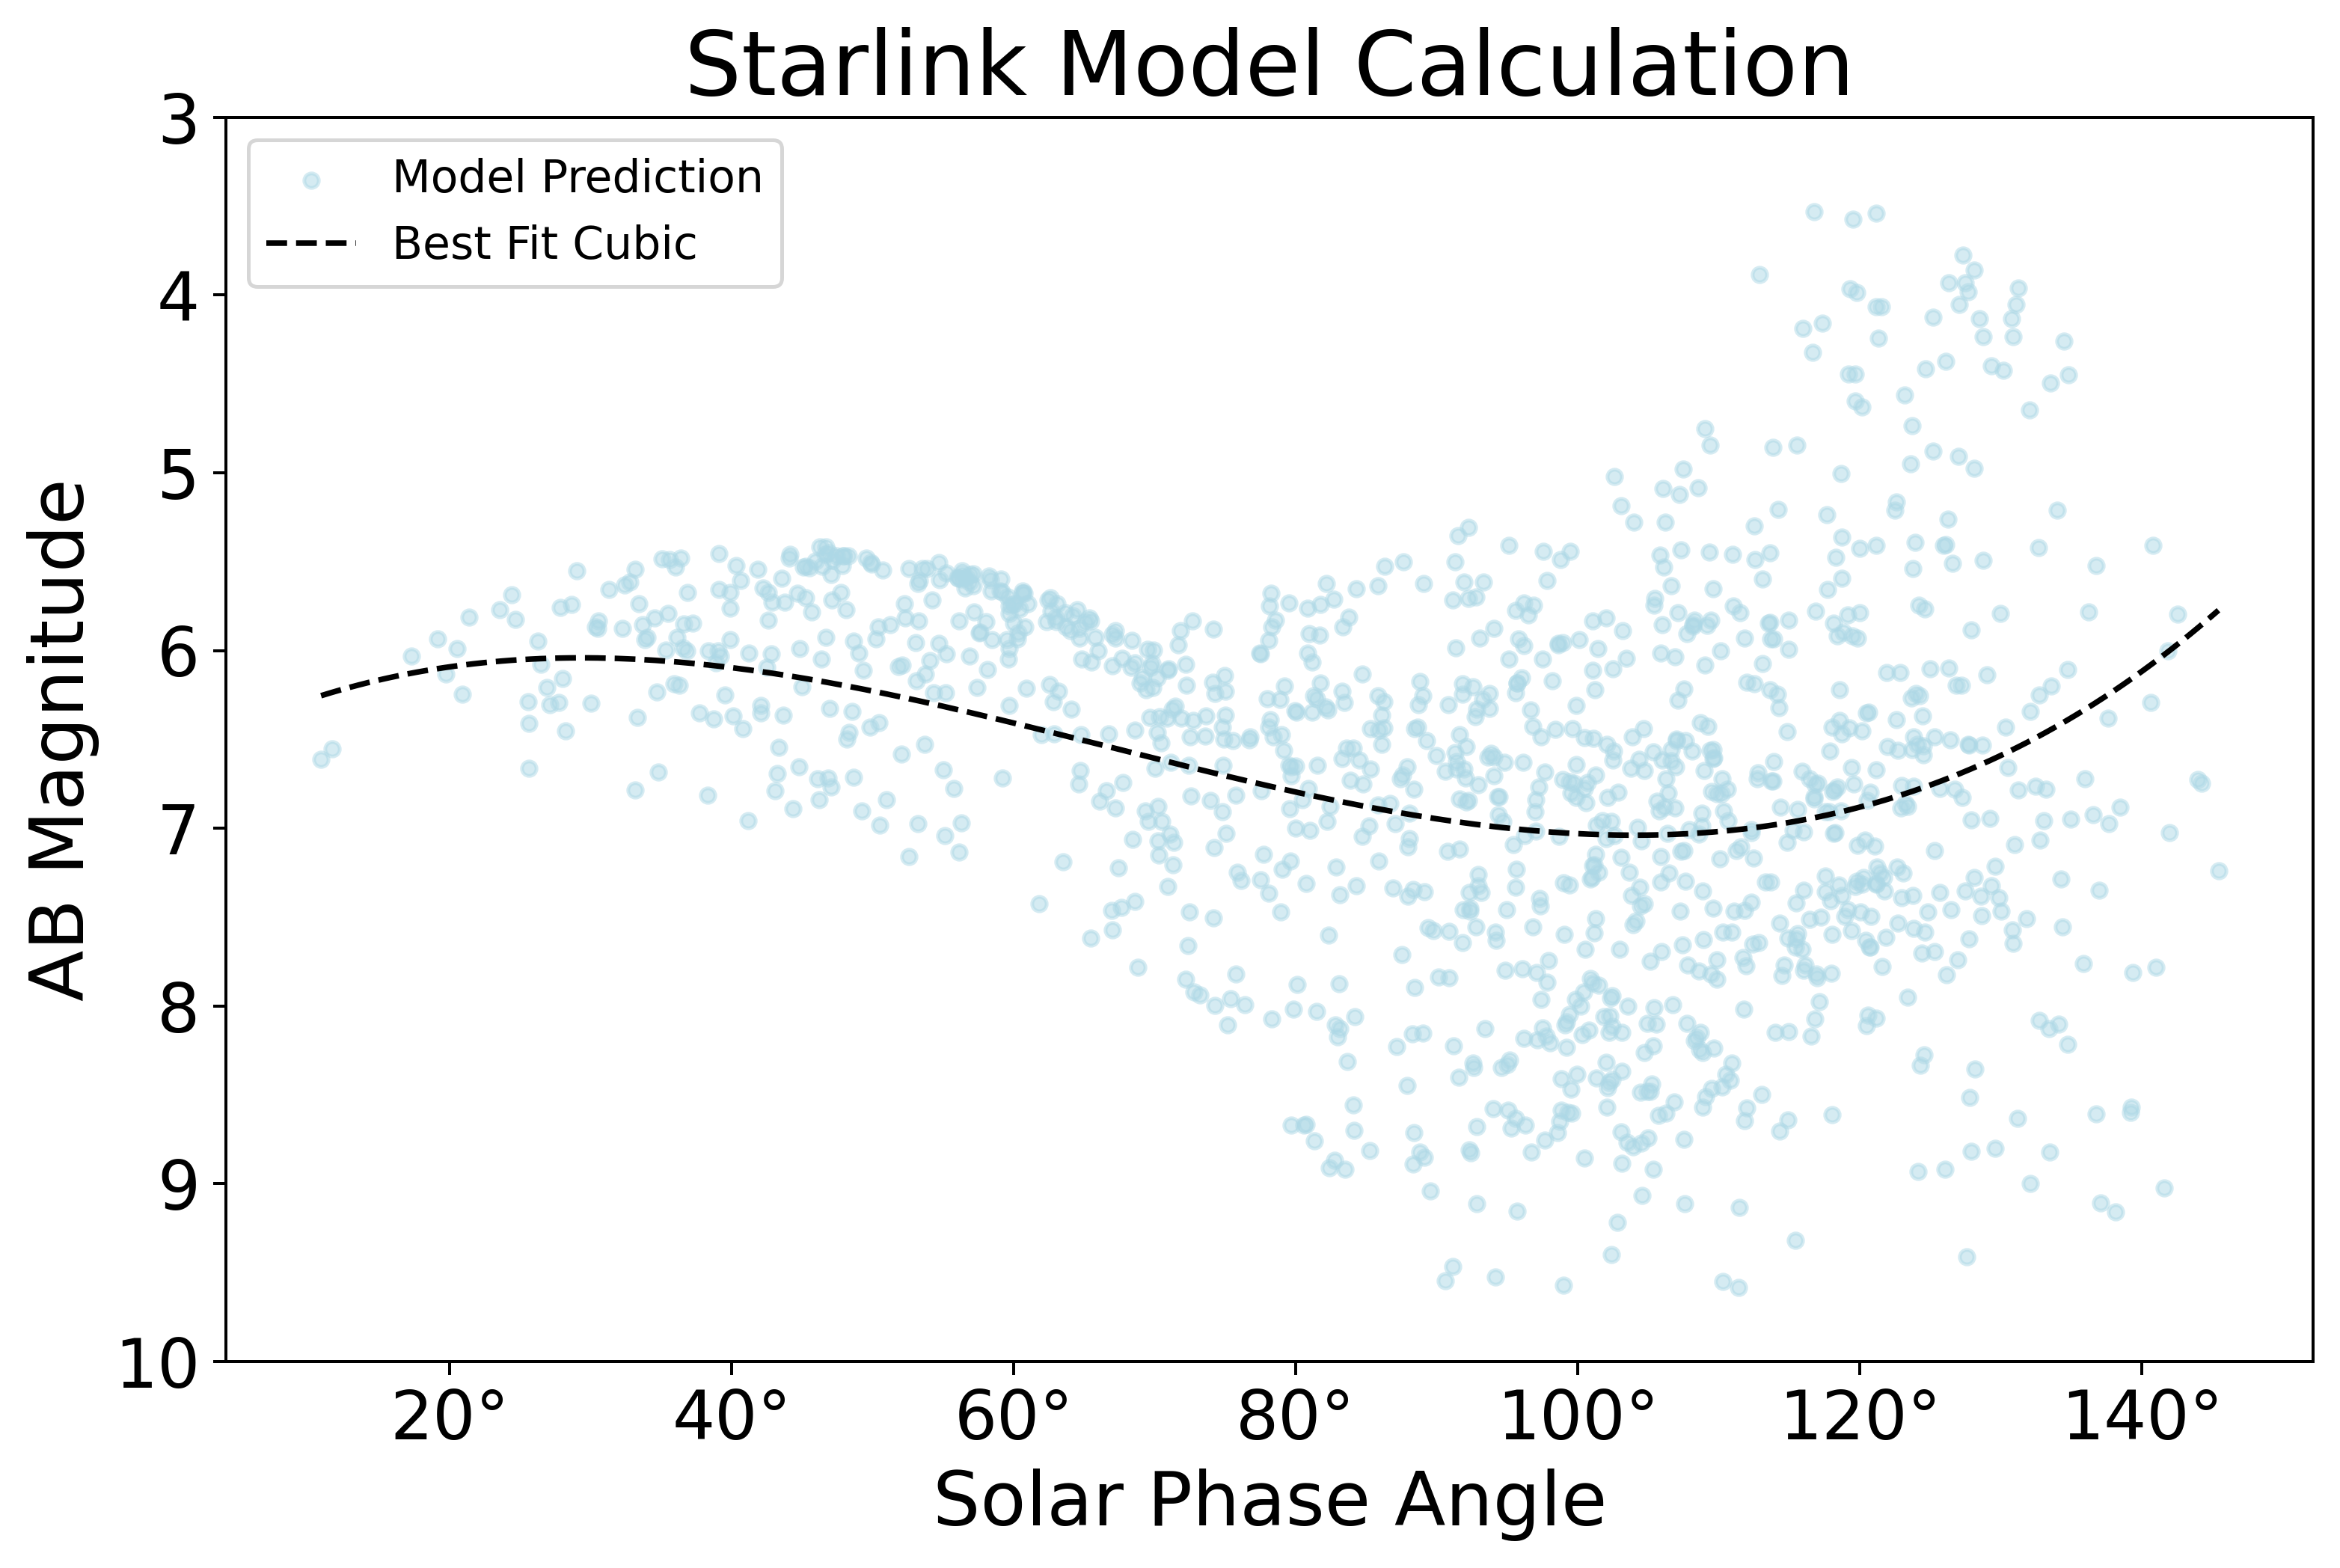

In [13]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=360)

# Configure plot axes and labels
ax.set_ylim(3, 10)
ax.invert_yaxis()  # Reverse y-axis since magnitude scale decreases with brightness
ax.set_xlabel("Solar Phase Angle", fontsize=20)
ax.set_ylabel("AB Magnitude", fontsize=20)
ax.set_title("Starlink Model Calculation", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))  # Format x-axis as degrees

# Plot calculated magnitudes against phase angles
ax.scatter(night_data['phase_angle'], night_data['lab_brdf_mag'],
           alpha=0.5, s=15, label="Model Prediction", color='lightblue')

if len(night_data) >= 4:
    a1, a2, a3, a4 = np.polyfit(night_data['phase_angle'],
                               night_data['lab_brdf_mag'], deg=3)
    x = np.linspace(night_data['phase_angle'].min(),
                   night_data['phase_angle'].max(), 200)
    y = a1*x**3 + a2*x**2 + a3*x + a4
    ax.plot(x, y, "--k", label="Best Fit Cubic")

# Add legend and display plot
ax.legend(loc=2, prop={'size': 12})
plt.show()

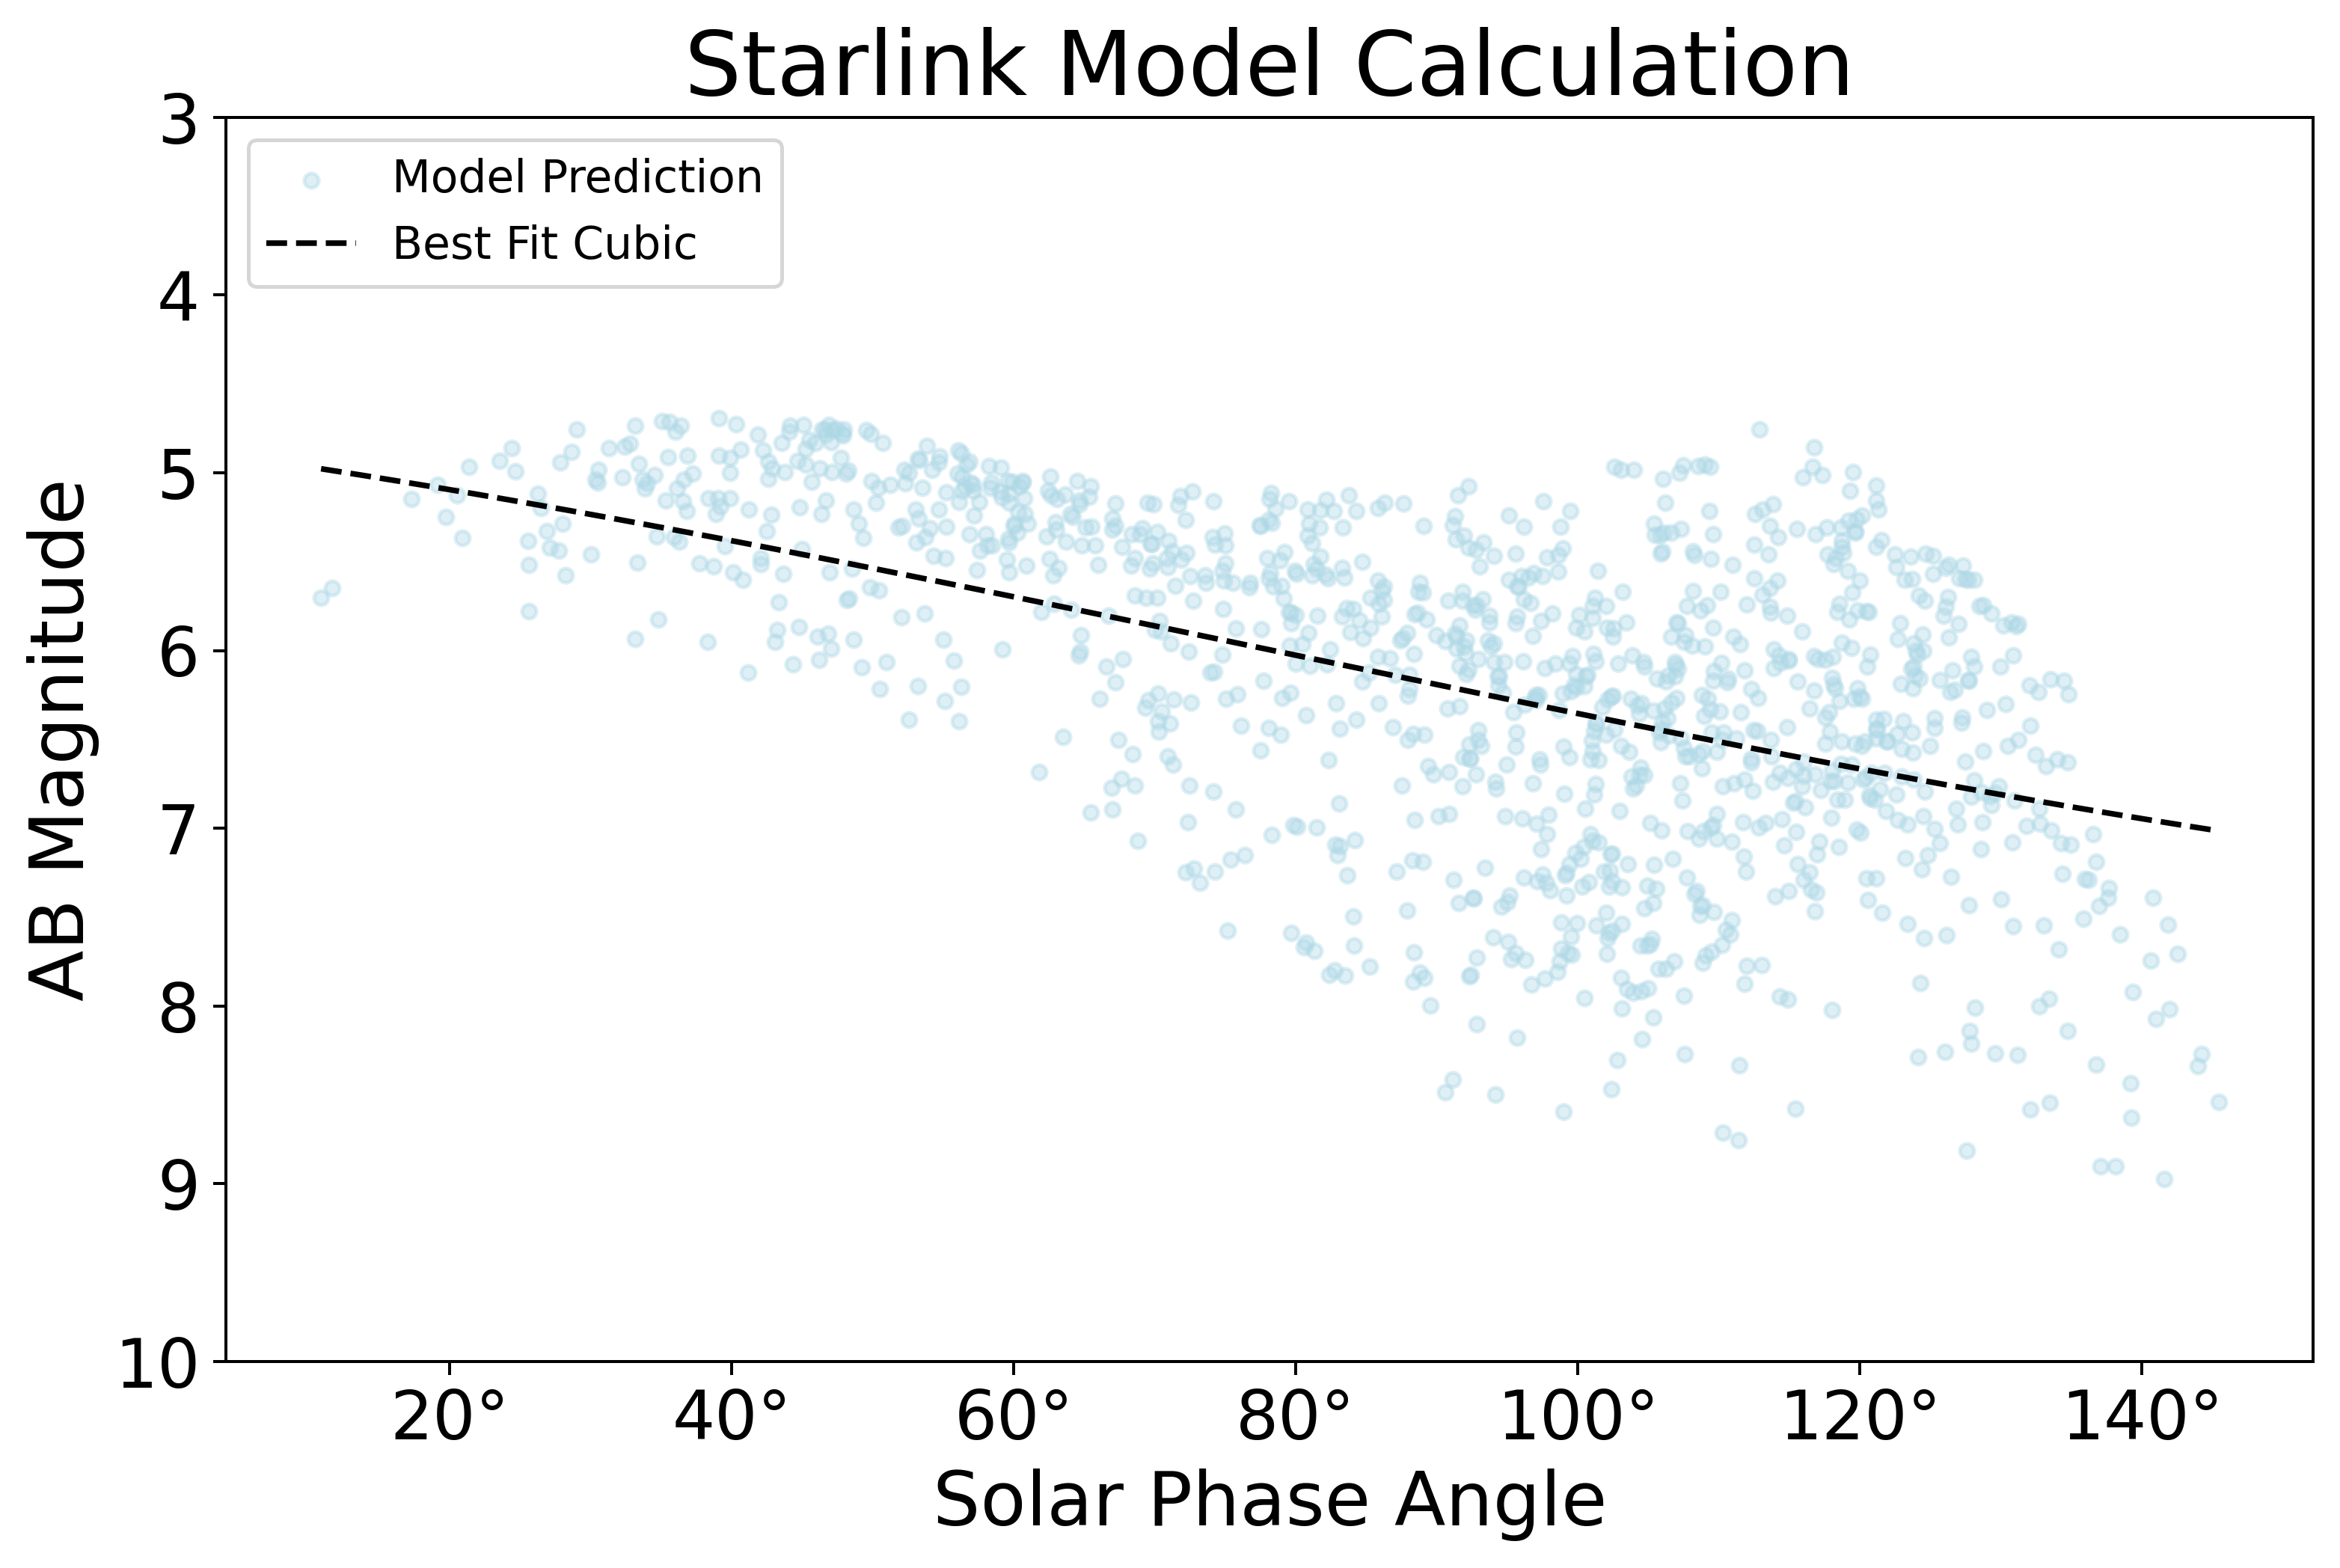

In [15]:
# Plotting
fig, ax = plt.subplots(1, 1, figsize=(10, 6), dpi=360)

# Configure plot axes and labels
ax.set_ylim(3, 10)
ax.invert_yaxis()  # Reverse y-axis since magnitude scale decreases with brightness
ax.set_xlabel("Solar Phase Angle", fontsize=20)
ax.set_ylabel("AB Magnitude", fontsize=20)
ax.set_title("Starlink Model Calculation", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.xaxis.set_major_formatter(StrMethodFormatter(u"{x:.0f}°"))  # Format x-axis as degrees

# Plot calculated magnitudes against phase angles
ax.scatter(night_data['phase_angle'], night_data['inferred_brdf_mag'],
           alpha=0.4, s=15, label="Model Prediction", color='lightblue')

if len(night_data) >= 4:
    a1, a2, a3, a4 = np.polyfit(night_data['phase_angle'],
                                night_data['inferred_brdf_mag'], deg=3)
    x = np.linspace(night_data['phase_angle'].min(),
                    night_data['phase_angle'].max(), 200)
    y = a1 * x ** 3 + a2 * x ** 2 + a3 * x + a4
    ax.plot(x, y, "--k", label="Best Fit Cubic")

# Add legend and display plot
ax.legend(loc=2, prop={'size': 12})
plt.show()